# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [0]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [0]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=44.50763585489293, pvalue=2.164161530255469e-10)


In [0]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## Live Lecture - let's explore some more of scipy.stats

Candidate topics to explore:

- `scipy.stats.chi2` - the Chi-squared distribution, which we can use to reproduce the Chi-squared test
- Calculate the Chi-Squared test statistic "by hand" (with code), and feed it into `chi2`
- Build a confidence interval with `stats.t.ppf`, the t-distribution percentile point function (the inverse of the CDF) - we can write a function to return a tuple of `(mean, lower bound, upper bound)` that you can then use for the assignment (visualizing confidence intervals)

In [0]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv', na_values=" ?")

In [0]:
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
country            583
salary               0
dtype: int64

In [0]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [0]:
df.describe(exclude='number')

,workclass,education,marital-status,occupation,relationship,race,sex,country,salary
count,30725,32561,32561,30718,32561,32561,32561,31978,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [0]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'country', 'salary'],
      dtype='object')

In [0]:
bins = [0,9,19,29,39,49,1000]

label_names = ['0-9','10-19','20-29','30-39','40-49','50+']

df['hours_per_week_cat'] = pd.cut(df['hours-per-week'], bins, labels=label_names)

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary,hours_per_week_cat
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,40-49
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,10-19
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,40-49
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,40-49
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,40-49


In [0]:
df['sex'].iloc[0]

' Male'

In [0]:
df['hours-per-week'].iloc[0]

40

In [0]:
df['sex'].value_counts()

 Male      21790
 Female    10771
Name: sex, dtype: int64

In [0]:
df = df.sort_values(by='hours_per_week_cat',ascending=True, axis=1)

In [0]:
conti_table = pd.crosstab(df['sex'], df['hours_per_week_cat'], margins=True)

In [0]:
# !pip install pandas==0.20.0

In [0]:
conti_table

hours_per_week_cat,0-9,10-19,20-29,30-39,40-49,50+,All
sex,,,,,,,
Female,235,671,1287,1914,5636,1028,10771
Male,223,575,1105,1753,12700,5434,21790
All,458,1246,2392,3667,18336,6462,32561


In [0]:
femalecount = conti_table.iloc[0][0:6].values
femalecount

array([ 235,  671, 1287, 1914, 5636, 1028])

In [0]:
malecount = conti_table.iloc[1][0:6].values
malecount

array([  223,   575,  1105,  1753, 12700,  5434])

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure

In [0]:
# get row sums

row_sums = conti_table.iloc[0:2, 6].values
col_sums = conti_table.iloc[2, 0:6].values

print(row_sums, col_sums)

[10771 21790] [  458  1246  2392  3667 18336  6462]


In [0]:
total = conti_table.loc['All', 'All']
total

32561

In [0]:
# create 2-d numpy array

expected = []

for i in range(len(row_sums)):
  expected_row = []
  for col in col_sums:
    expected_val = col*row_sums[i]/total
    expected_row.append(expected_val)
  expected.append(expected_row)
  
print(np.array(expected))

[[  151.50388502   412.16995793   791.26046497  1213.02346365
   6065.44811277  2137.59411566]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


In [0]:
observed = pd.crosstab(df['sex'], df['hours_per_week_cat']).values

observed

array([[  235,   671,  1287,  1914,  5636,  1028],
       [  223,   575,  1105,  1753, 12700,  5434]])

In [0]:
chi_squared = ((observed - expected)**2/(expected)).sum()

chi_squared

2287.190943926107

In [0]:
dof = (len(row_sums)-1)*(len(col_sums)-1)
dof

5

In [0]:
import scipy.stats as stats

In [0]:
chi_squared, p_value, dof, expected = stats.chi2_contingency(observed)



In [0]:
np.array(expected)

array([[  151.50388502,   412.16995793,   791.26046497,  1213.02346365,
         6065.44811277,  2137.59411566],
       [  306.49611498,   833.83004207,  1600.73953503,  2453.97653635,
        12270.55188723,  4324.40588434]])

In [0]:
coinflips = np.random.binomial(n=1,p=.5,size=100)

coinflips

array([0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0])

In [0]:
stats.ttest_1samp(coinflips,.5)

Ttest_1sampResult(statistic=0.5980699588110717, pvalue=0.5511590111236769)

In [0]:
coinflips1000 = np.random.binomial(n=1,p=.5,size=1000)

In [0]:
coinflips.mean()

0.53

In [0]:
coinflips1000.mean()

0.515

In [0]:
np.std(coinflips)

0.4990991885387111

In [0]:
np.std(coinflips1000)

0.49977494935220584

In [0]:
stats.sem(coinflips)

0.05016135580465918

In [0]:
stats.sem(coinflips1000)

0.01581217964181488

In [0]:
def con_in(data, confidence=0.95):
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1+confidence)/2.0, n-1)
  return (mean, mean-interval, mean+interval)

def report_confidence_interval(confidence_interval):
  """
  Return a string with a pretty report of a confidence interval.
  
  Arguments:
    confidence_interval - tuple of (mean, lower bound, upper bound)
  
  Returns:
    None, but prints to screen the report
  """
  #print('Mean: {}'.format(confidence_interval[0]))
  #print('Lower bound: {}'.format(confidence_interval[1]))
  #print('Upper bound: {}'.format(confidence_interval[2]))
  s = "our mean lies in the interval [{:.5}, {:.5}]".format(
      confidence_interval[1], confidence_interval[2])
  return s

In [0]:
def conf_interval(pd_series, conf=0.95):
    assert type(pd_series) == pd.core.series.Series
    
    #print(np_series.mean())
    ci = pd_series.std(ddof=1) * st.t.ppf((1 + conf) / 2., len(pd_series) - 1)

    return pd_series.mean() - ci, pd_series.mean(), pd_series.mean() + ci

In [0]:
# stats.t.interval

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

In [0]:
# TODO - your code! use density plot or histogram with error bars or box plot with whiskers

import pandas as pd

import numpy as np

import scipy.stats as stats

import matplotlib.pyplot as plt

import seaborn as sns

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', header=None)

df = df.rename(columns={0:'party',1:'handicapped-infants',2:'water-project',3:'budget',4:'physician-fee-freeze',5:'el-salvador-aid',6:'religious-groups',7:'anti-satellite-ban',8:'aid-to-contras',9:'mx-missile',10:'immigration',11:'synfuels',12:'education',13:'right-to-sue',14:'crime',15:'duty-free',16:'south-africa'})

df = df.replace(["?", "y", "n"], [np.NaN, 1, 0])

df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
df = df.dropna()

In [0]:
rep = df[df['party']=='republican']
dem = df[df['party']=='democrat']

<BarContainer object of 1 artists>

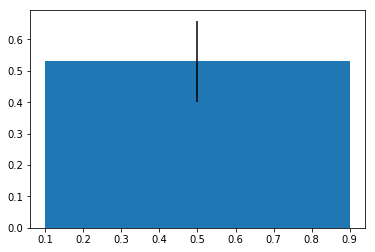

In [50]:
fig, ax = plt.subplots()
ax.bar(1
       , budget[0], yerr=(budget[1]-budget[2]))

In [8]:
df.shape

(232, 17)

In [0]:
budget = con_in(df['budget'])

In [51]:
conf_interval(df['budget'])

NameError: ignored

In [30]:
budget[0]

0.5301724137931034

In [42]:
df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
19,democrat,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
23,democrat,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
25,democrat,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [0]:
rep['immigration'].pot

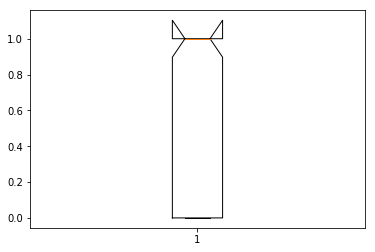

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot(df['budget'], notch=True);

IndexError: ignored

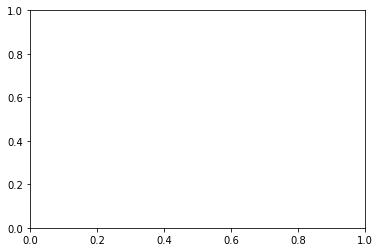

In [28]:
fig, ax = plt.subplots()
ax.boxplot(df['budget'].values,conf_intervals=[budget[1],budget[2]],usermedians=budget[0])


<ErrorbarContainer object of 3 artists>

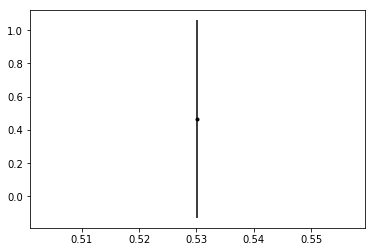

In [16]:
|plt.errorbar(budget[0], budget[1], yerr=budget[2], fmt='.k')



In [0]:
visuals = df[['budget','immigration','education']]

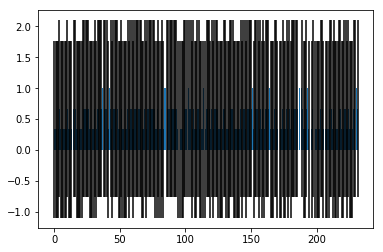

In [37]:
mean = visuals.mean(axis = 1)
std = visuals.std(axis = 1)

n= visuals.shape[1]
yerr = std / np.sqrt(n) * stats.t.ppf(1-0.05/2, n - 1)

plt.figure()
plt.bar(range(visuals.shape[0]), mean, yerr = yerr) 
plt.show() 

In [0]:
vis - df[['party', 'aid']

In [35]:
fig, ax = plt.subplots()

ax.barh(vis['party'], vis['aid-to-contras'], xerr=vis['xerr'], align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Support')
ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%'])
ax.set_yticklabels(['Democrats', 'Republicans'])
ax.set_title('Partisan Support for the Contra Aid Bill')

plt.show()

(232, 17)

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)